In [2]:
import pandas as pd
global_temp = pd.read_csv("GlobalTemperatures.csv")
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.info())
print(global_temp.isnull().sum())

(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   

## Persiapan Data

In [3]:
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)
    

In [4]:
import pandas as pd

def converttemp(x):
    x = (x * 1.8) + 32
    return float(x)

def wrangle(df):
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"] = df["dt"].dt.month
    df["Year"] = df["dt"].dt.year
    df = df.drop("dt", axis=1)
    df = df.drop("Month", axis=1)
    df = df[df.Year >= 1850]
    df = df.set_index(["Year"])
    df = df.dropna()
    return df




## Visualisasi

dt                                           datetime64[ns]
LandAverageTemperature                              float64
LandAverageTemperatureUncertainty                   float64
LandMaxTemperature                                  float64
LandMaxTemperatureUncertainty                       float64
LandMinTemperature                                  float64
LandMinTemperatureUncertainty                       float64
LandAndOceanAverageTemperature                      float64
LandAndOceanAverageTemperatureUncertainty           float64
dtype: object
dt                                           datetime64[ns]
LandAverageTemperature                              float64
LandAverageTemperatureUncertainty                   float64
LandMaxTemperature                                  float64
LandMaxTemperatureUncertainty                       float64
LandMinTemperature                                  float64
LandMinTemperatureUncertainty                       float64
LandAndOceanAverageTempera

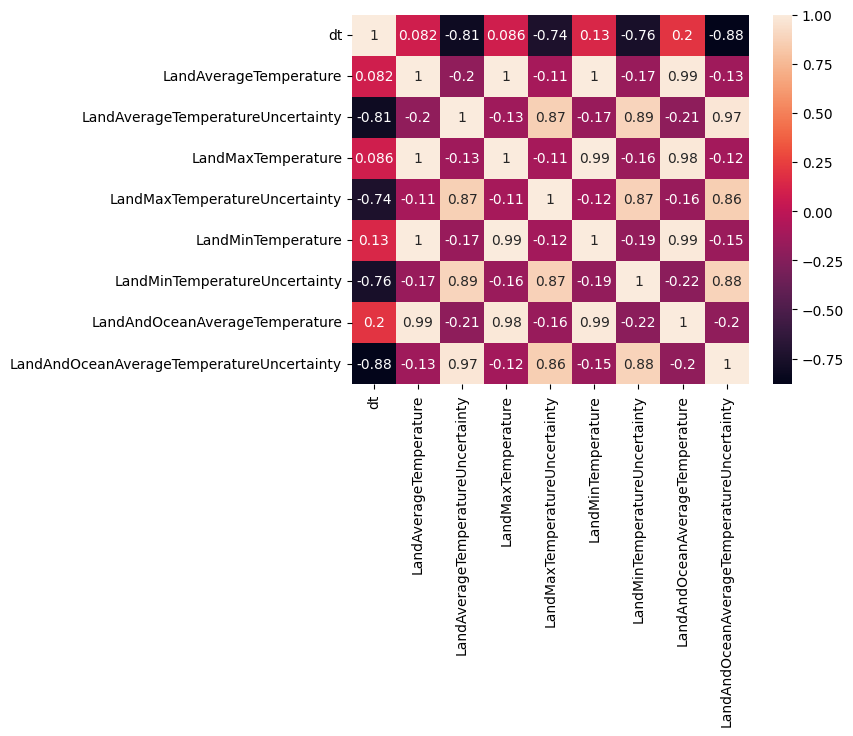

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Contoh DataFrame global_temp
# global_temp = pd.read_csv('your_dataset.csv')

# Konversi kolom 'dt' menjadi datetime jika belum dikonversi
if 'dt' in global_temp.columns:
    global_temp['dt'] = pd.to_datetime(global_temp['dt'], errors='coerce')

# Periksa tipe data dari setiap kolom
print(global_temp.dtypes)

# Hapus kolom non-numerik atau kolom yang tidak diperlukan untuk korelasi
columns_to_drop = [col for col in global_temp.columns if global_temp[col].dtype == 'object']
global_temp_numeric = global_temp.drop(columns=columns_to_drop)

# Pastikan hanya kolom numerik yang tersisa
print(global_temp_numeric.dtypes)

# Hitung matriks korelasi
corrMatrix = global_temp_numeric.corr()

# Plot heatmap dari matriks korelasi
sns.heatmap(corrMatrix, annot=True)
plt.show()


## Memisahkan Target Kita untuk Memprediksi Cuaca

In [6]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

## Train Test Split

In [7]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)
print(xtrain.shape)
print(xval.shape)
print(ytrain.shape)
print(yval.shape)

(2394, 3)
(798, 3)
(2394,)
(798,)


## Baseline Mean Absolute Error

In [8]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Periksa apakah terdapat nilai NaN dalam y_train
print("Jumlah nilai NaN dalam y_train:", np.isnan(ytrain).sum())

# Menghapus nilai NaN dari y_train
y_train_clean = ytrain[~np.isnan(ytrain)]

# Buat prediksi baseline dengan mean dari y_train_clean
ypred = [y_train_clean.mean()] * len(y_train_clean)

# Hitung Mean Squared Error (MSE) untuk baseline
print("Baseline MSE: ", round(mean_squared_error(y_train_clean, ypred), 5))


Jumlah nilai NaN dalam y_train: 881
Baseline MSE:  1.58453


## Training Model Untuk Memprediksi Cuaca

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Mengimputasi nilai NaN dalam ytrain
imputer_y = SimpleImputer(strategy='mean')
ytrain_imputed = imputer_y.fit_transform(ytrain.values.reshape(-1, 1)).ravel()

# Membuat pipeline dengan SimpleImputer, SelectKBest, StandardScaler, dan RandomForestRegressor
forest = make_pipeline(
    SimpleImputer(strategy='mean'),  
    SelectKBest(k="all"),            
    StandardScaler(),                
    RandomForestRegressor(
        n_estimators=100,            
        max_depth=50,                
        random_state=77,            
        n_jobs=-1                  
    )
)

# Melatih model dengan data pelatihan yang sudah diimputasi
forest.fit(xtrain, ytrain_imputed)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

## Evaluasi Model Pembelajaran Mesin untuk Memprediksi Cuaca

In [11]:
# Melakukan prediksi dengan data validasi
ypred = forest.predict(xval)

# Menghitung kesalahan dan akurasi
errors = abs(ypred - yval)
mape = 100 * (errors / yval)
accuracy = 100 - np.mean(mape)

print("Random Forest Model: ", round(accuracy, 2), "%")

Random Forest Model:  99.11 %
